In [725]:
import numpy as np
import pandas as pd
import time

In [726]:
import mysql.connector
mydb = mysql.connector.connect(
  host="localhost",
  user="zetyaa",
  password="12345",
  database="cbr_restoran"
)

query = "SELECT * FROM dataset_restoran"
data = pd.read_sql(query, con=mydb)

c:\Users\Komang Putra\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [727]:
# Cek Data NULL
data.isnull().sum()

No           0
Nama         0
Menu         0
Daerah       0
Tempat       0
Kategori     0
Jenis        0
Rasa         0
Harga        0
Rating       0
Latitude     0
Longitude    0
Telepon      0
dtype: int64

In [728]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   No         100 non-null    int64  
 1   Nama       100 non-null    object 
 2   Menu       100 non-null    object 
 3   Daerah     100 non-null    object 
 4   Tempat     100 non-null    object 
 5   Kategori   100 non-null    object 
 6   Jenis      100 non-null    object 
 7   Rasa       100 non-null    object 
 8   Harga      100 non-null    int64  
 9   Rating     100 non-null    float64
 10  Latitude   100 non-null    float64
 11  Longitude  100 non-null    float64
 12  Telepon    100 non-null    object 
dtypes: float64(3), int64(2), object(8)
memory usage: 10.3+ KB


# Data Preparation

**Mengelompokkan Harga**

In [729]:
# mengelompokkan harga
batas_bin = [0, 19999, 39999, 59999, 100000]
kategori = ['10K', '30K', '50K', '>50K']
data['range_harga'] = pd.cut(data['Harga'], bins=batas_bin, labels=kategori)

**Mengelompokkan Rating**

In [730]:
# mengelompokkan rating
batas_bin = [3, 4, 4.3, 4.6, 5]
kategori = ['Cukup', ' Cukup Baik', 'Baik', 'Sangat Baik']
data['range_rating'] = pd.cut(data['Rating'], bins=batas_bin, labels=kategori)

# Preprocessing Data

**Create Table**

In [731]:
# membentuk tabel baru
old_case = ['Daerah', 'Tempat', 'Kategori', 'Jenis', 'Rasa', 'range_harga', 'range_rating']
old_case = data[old_case]
old_case.head()

,Daerah,Tempat,Kategori,Jenis,Rasa,range_harga,range_rating
0,Denpasar Utara,Warung,Babi,Babi Guling,Gurih,10K,Baik
1,Denpasar Utara,Warung,Babi,Babi Guling,Pedas,10K,Baik
2,Denpasar Selatan,Warung,Babi,Babi Guling,Pedas,30K,Sangat Baik
3,Denpasar Utara,Warung,Babi,Babi Guling,Pedas,30K,Baik
4,Denpasar Utara,Warung,Babi,Babi Guling,Gurih,10K,Baik


**User Input Data**

In [732]:
daerah = 'Sanur' 
tempat = 'Hotel' 
kategori = 'Sapi' 
jenis = 'Rendang' 
rasa = 'Asem' 
harga = '100K' 
rating = 'Mantap'

new_Case = {
    'Daerah':[daerah],
    'Tempat':[tempat],
    'Kategori':[kategori],
    'Jenis':[jenis],
    'Rasa':[rasa],
    'range_harga':[harga],
    'range_rating':[rating]
}

new_case = pd.DataFrame(new_Case)
new_case.head()

,Daerah,Tempat,Kategori,Jenis,Rasa,range_harga,range_rating
0,Sanur,Hotel,Sapi,Rendang,Asem,100K,Mantap


**Merge Kasus Lama dan Baru**

In [733]:
start_time = time.time()

In [734]:
mergeData = [old_case, new_case]
mergeData = pd.concat(mergeData).reset_index(drop=True)

In [735]:
mergeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Daerah        101 non-null    object
 1   Tempat        101 non-null    object
 2   Kategori      101 non-null    object
 3   Jenis         101 non-null    object
 4   Rasa          101 non-null    object
 5   range_harga   101 non-null    object
 6   range_rating  101 non-null    object
dtypes: object(7)
memory usage: 5.6+ KB


**One Hot Encoding**

In [693]:
#Convert data lama kategrorikal menjadi numerik
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in mergeData.columns:
    mergeData[i]=le.fit_transform(mergeData[i])

**Split Old Case and New Case**

In [694]:
oldCase = mergeData.iloc[:-1]
newCase = mergeData.iloc[-1:]

# Indexing dengan K-Means

**Scaling Old Data**

In [695]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(oldCase)
old_scaled = scaler.transform(oldCase)
old_scaled = pd.DataFrame(old_scaled)

**Scaling All Data**

In [696]:
scaler = StandardScaler()
scaler.fit(mergeData)
all_scaled = scaler.transform(mergeData)
all_scaled = pd.DataFrame(all_scaled)

In [697]:
# mengambil value scale kasus baru
coordInit = all_scaled.iloc[-1:]

**Clustering Data**

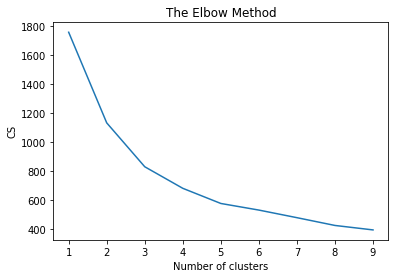

In [698]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
cs = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(oldCase)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 10), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [699]:
kmeans = KMeans(n_clusters=3)
y_predicted = kmeans.fit_predict(old_scaled) 
oldCase['Cluster'] = y_predicted

C:\Users\Komang Putra\AppData\Local\Temp\ipykernel_20176\995161883.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oldCase['Cluster'] = y_predicted


**Euclidean Distance Between New Case And Centroid**

In [700]:
#centroid cluster
listCentroid = kmeans.cluster_centers_

In [701]:
import math
distance = list()
for i in range(len(listCentroid)):
    coordFinal = listCentroid[i]

    #distance from old with centroid
    dist = math.sqrt(((coordInit[0] - coordFinal[0]) ** 2) 
                    + ((coordInit[1] - coordFinal[1]) ** 2) 
                    + ((coordInit[2] - coordFinal[2]) ** 2)
                    + ((coordInit[3] - coordFinal[3]) ** 2)
                    + ((coordInit[4] - coordFinal[4]) ** 2)
                    + ((coordInit[5] - coordFinal[5]) ** 2)
                    + ((coordInit[6] - coordFinal[6]) ** 2))
    distance.append(dist)

**Mendapatkan Posisi Cluster Untuk Kasus Baru**

In [702]:
minpos = distance.index(min(distance))
newCase['Cluster'] = minpos
minpos

C:\Users\Komang Putra\AppData\Local\Temp\ipykernel_20176\1144293685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newCase['Cluster'] = minpos


2

**Create Cluster**

In [703]:
#Merge Data
restaurant = [oldCase, newCase]
restaurant = pd.concat(restaurant).reset_index(drop=True)

# count feature cluster
restaurant.groupby('Cluster')['Cluster'].count()

Cluster
0    52
1    38
2    11
Name: Cluster, dtype: int64

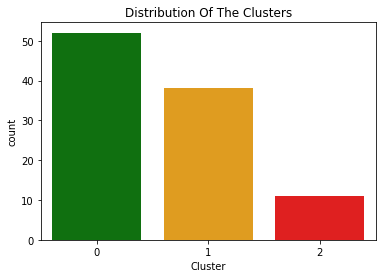

In [704]:
import seaborn as sns
pal = ['green','orange','red']
pl = sns.countplot(x=restaurant["Cluster"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

**Tabel Cluster Kasus Baru**

In [705]:
restaurant['Cluster']=restaurant['Cluster'].astype('int32')
newCluster = restaurant.loc[restaurant["Cluster"] == minpos]
newCluster

,Daerah,Tempat,Kategori,Jenis,Rasa,range_harga,range_rating,Cluster
32,4,1,0,3,4,1,0,2
44,9,1,1,1,4,2,0,2
56,1,1,1,1,4,3,0,2
59,0,1,0,3,4,1,0,2
69,0,1,0,3,4,2,1,2
73,0,1,1,1,2,1,1,2
83,12,1,1,2,3,1,0,2
93,0,1,1,1,2,1,0,2
94,1,1,1,1,2,1,0,2
97,1,1,1,1,4,2,1,2


# Similarity dengan K-Nearest Neighbor

**Pembobotan**

In [706]:
bobot = [10, 8, 10, 7, 4, 6, 7]
jumlah_bobot = sum(bobot)
total_rows = len(newCluster.index)

In [707]:
xdaerah = []
for j in range(total_rows-1):
  if newCluster.iloc[-1,0] != newCluster.iloc[j,0]:
    xdaerah.append(0)
  elif newCluster.iloc[-1,0] == newCluster.iloc[j,0]:
    xdaerah.append(bobot[0])

In [708]:
xtempat = []
for j in range(total_rows-1):
  if newCluster.iloc[-1,1] != newCluster.iloc[j,1]:
    xtempat.append(0)
  elif newCluster.iloc[-1,1] == newCluster.iloc[j,1]:
    xtempat.append(bobot[1])

In [709]:
xkategori = []
for j in range(total_rows-1):
  if newCluster.iloc[-1,2] != newCluster.iloc[j,2]:
    xkategori.append(0)
  elif newCluster.iloc[-1,2] == newCluster.iloc[j,2]:
    xkategori.append(bobot[2])

In [710]:
xjenis = []
for j in range(total_rows-1):
  if newCluster.iloc[-1,3] != newCluster.iloc[j,3]:
    xjenis.append(0)
  elif newCluster.iloc[-1,3] == newCluster.iloc[j,3]:
    xjenis.append(bobot[3])

In [711]:
xrasa = []
for j in range(total_rows-1):
  if newCluster.iloc[-1,4] != newCluster.iloc[j,4]:
    xrasa.append(0)
  elif newCluster.iloc[-1,4] == newCluster.iloc[j,4]:
    xrasa.append(bobot[4])

In [712]:
xharga = []
for j in range(total_rows-1):
  if newCluster.iloc[-1,5] != newCluster.iloc[j,5]:
    xharga.append(0)
  elif newCluster.iloc[-1,5] == newCluster.iloc[j,5]:
    xharga.append(bobot[5])

In [713]:
xrating = []
for j in range(total_rows-1):
  if newCluster.iloc[-1,6] != newCluster.iloc[j,6]:
    xrating.append(0)
  elif newCluster.iloc[-1,6] == newCluster.iloc[j,6]:
    xrating.append(bobot[6])

**Perhitungan Similarity**

In [714]:
similarity = []
for j in range (total_rows-1):
  similarity.append(round((xdaerah[j] + xtempat[j] + xkategori[j] + xjenis[j] + xrasa[j] + xharga[j] + xrating[j]) / jumlah_bobot * 100,2))

similarity = np.array(similarity)

In [715]:
index = []
for j in range (total_rows-1):
  index.append(newCluster.index[j])

index = np.array(index)

In [716]:
dataframe_similarity=pd.DataFrame(index, columns=['Index']) 
dataframe_similarity['Nilai_Similarity'] = similarity

In [717]:
treshold_resto = dataframe_similarity.loc[(dataframe_similarity.Nilai_Similarity >= 70)]
treshold_resto = treshold_resto.sort_values('Nilai_Similarity',ascending=False)
treshold_resto

,Index,Nilai_Similarity


In [718]:
end_time = time.time()
total_time = end_time - start_time
print("Waktu komputasi: ", total_time, " detik")

Waktu komputasi:  2.2060530185699463  detik


**Hasil Rekomendasi**

In [719]:
solusi = treshold_resto.Index
solusi = np.array(solusi)
data_list = []
len_solution = len(treshold_resto)

if len_solution == 0:
    #Jika tidak ada rekomendasi masuk ke revise
    print("Mohon maaf, tidak ada rekomendasi untuk restoran yang anda cari \n Mohon menunggu pakar dalam mencari rekomendasi yang sesuai untuk anda")
    mycursor = mydb.cursor()
    revise_sql = "INSERT INTO revise (Daerah, Tempat, Kategori, Jenis, Rasa, Harga, Rating, Status) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"
    revise_src = (daerah, tempat, kategori, jenis, rasa, harga, rating, 0)
    mycursor.execute(revise_sql, revise_src)
    mydb.commit() 
else:
    #masukan data ke hasil
    for i in range(min(5, max(1, len(solusi)))):
        data_list.append(data.loc[solusi[i]])
    result = pd.DataFrame(data_list)

    # merge hasil similarity dengan rekomendasi
    result['Similarity'] = treshold_resto['Nilai_Similarity'].values[:len(data_list)]

Mohon maaf, tidak ada rekomendasi untuk restoran yang anda cari 
 Mohon menunggu pakar dalam mencari rekomendasi yang sesuai untuk anda


In [720]:
## SEMISAL AKU MAU CHECK KALO SEMISAL ADA NAMA RESTORAN YANG SAMA DIPILIH SIMILARITY YG PALING GEDE AJA, YANG KECIL GA MASUK
## TAPI DATANYA BIAR TETEP 5, KALO LEWATIN TAHAP INI KAN UDH DI FILTER JADI 5 KALO ADA 2 DATA SAMA BERKURANG JADI 4
# result = result.groupby('Nama')['Nilai_Similarity'].idxmax()

# Output

**Nilai Threshold**

In [721]:
treshold_resto['Nilai_Similarity']

Series([], Name: Nilai_Similarity, dtype: float64)

**Rekomendasi**

In [722]:
result

,No,Nama,Menu,Daerah,Tempat,Kategori,Jenis,Rasa,Harga,Rating,Latitude,Longitude,Telepon,range_harga,range_rating,Similarity
10,11,Wr. Murni Asih,Babi Guling Khas Gianyar,Denpasar Selatan,Warung,Babi,Babi Guling,Pedas,17000,4.4,-8.678132,115.224462,-,10K,Baik,100.00
46,47,"Wr. Babi Guling Singaraja ""Rendi""",Babi Guling Biasa,Denpasar Selatan,Warung,Babi,Babi Guling,Pedas,15000,4.6,-8.690663,115.224660,85239697405,10K,Baik,100.00
37,38,Warung Celuk,Nasi Campur Ayam / Babi,Denpasar Selatan,Warung,Babi,Babi Guling,Pedas,10000,4.7,-8.683615,115.221227,8123690214,10K,Sangat Baik,86.54
1,2,Wr. Babi Guling Mawar,Babi Guling,Denpasar Utara,Warung,Babi,Babi Guling,Pedas,18000,4.5,-8.627955,115.208472,81805313408,10K,Baik,80.77
51,52,Babi Guling Sading,Nasi Babi Guling,Denpasar,Warung,Babi,Babi Guling,Pedas,10000,4.6,-8.609538,115.238646,-,10K,Baik,80.77
